**Ninh Giang Nguyen**

Spring 2025

CS343: Neural Networks

Project X: Predict Adoption via GNN on Facebook Data

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=7)

# Automatically reload your external source code
%reload_ext autoreload
%autoreload 0

##  Load the graph

In [257]:
import networkx as nx
G = nx.read_edgelist("facebook_combined.txt", create_using=nx.Graph(), nodetype=int)
print(G)

Graph with 4039 nodes and 88234 edges


1. Overview
* This dataset consists of circle (friends lists), node features (profiles) and ego network from Facebook. 

* Facebook data has been anonymized by replacing the Facebook-internal ids for each user with a new value. Also, while feature vectors from this dataset have been provided, the interpretation of those features has been hidden. 

2. Data description
* nodeId.edges : The edges in the ego network for the node 'nodeId'. Edges are undirected for facebook, and directed (a follows b) for twitter and gplus. The 'ego' node does not appear, but it is assumed that they follow every node id that appears in this file.

* nodeId.circles : The set of circles for the ego node. Each line contains one circle, consisting of a series of node ids. The first entry in each line is the name of the circle.

* nodeId.feat : The features for each of the nodes that appears in the edge file.

* nodeId.egofeat : The features for the ego user.

* nodeId.featnames : The names of each of the feature dimensions. Features are '1' if the user has this property in their profile, and '0' otherwise. This file has been anonymized for facebook users, since the names of the features would reveal private data.

##  Extract node features

In [258]:
degree_dict = dict(G.degree)    # number of friends 
clustering_dict = nx.clustering(G)      # neighborhood influence
activity_dict = {node: np.random.poisson(degree_dict[node] / 2 + 1) for node in G.nodes()}        # How active a user is
# print(activity_dict)

# Combines features into a single feature matrix
features = pd.DataFrame({
    "node": list(G.nodes()),
    "degree": [degree_dict[n] for n in G.nodes()],
    "activity": [activity_dict[n] for n in G.nodes()],
    "clustering": [clustering_dict[n] for n in G.nodes()]
})

print(features)

      node  degree  activity  clustering
0        0     347       176    0.041962
1        1      17         8    0.419118
2        2      10         9    0.888889
3        3      17        15    0.632353
4        4      10         2    0.866667
...    ...     ...       ...         ...
4034  4034       2         1    1.000000
4035  4035       1         0    0.000000
4036  4036       2         3    1.000000
4037  4037       4         3    0.666667
4038  4038       9         3    0.555556

[4039 rows x 4 columns]


## Create Lables (Adopt (1) vs not Adopt (0))

In [259]:
# choose 10% of users to be early adopters. 

rate = 0.1
num_adopters = int(rate*G.number_of_nodes())
adopters = np.random.choice(G.nodes(), size = num_adopters, replace = False)
label_dict = {node: 1 if node in adopters else 0 for node in G.nodes()}

print("First choose 10% of users to be early adopter:")
print(label_dict)

# then propagate adoption based on neighbors
iteration = 1
threshold = 3
for i in range(iteration):
    new_labels = label_dict.copy()
    for node in G.nodes():
        if label_dict[node] == 0: # not adopted yet
            adopted_neighbors = sum(label_dict[neighbor] for neighbor in G.neighbors(node))
            if adopted_neighbors >= threshold:
                new_labels[node] = 1 # update
    label_dict = new_labels

labels = [label_dict[n] for n in G.nodes()]

print("\nThen propagate adoption based on neighbors")
print(label_dict)

First choose 10% of users to be early adopter:
{0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 1, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 1, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 1, 66: 1, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 1, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 1, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 1, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 1, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 1, 121: 0, 122: 0, 123: 0, 124: 1, 125: 1, 126: 0, 127: 1, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0

## Implementation with PyG format

1. Convert networkx graph to PyG graph

In [260]:
from torch_geometric.utils import from_networkx
import torch
from torch_geometric.data import Data

# Convert networkx graph to PyG graph
G_pyg = from_networkx(G)

# Prepare node features
features_pyg = torch.tensor(features[["degree", "activity", "clustering"]].values, dtype = torch.float)
labels_pyg = torch.tensor(labels, dtype = torch.long)

G_pyg.x = features_pyg
G_pyg.y = labels_pyg

2. Create ego-network samples 

In [261]:
import torch_sparse
import torch_geometric
import torch_scatter

from torch_geometric.loader import NeighborSampler 

# prepare neighbor sampler (1-hop or 2-hop neighbors)
sampler = NeighborSampler(
    edge_index = G_pyg.edge_index,
    sizes = [10, 5], # sample up to 10 1-hop ones, 5 2-hop ones
    batch_size = 64, shuffle = True, num_workers = 0
)

3. Build the model with GraphSAGE + MLP (multiple layers)

* Because my Facebook ego-graph + binary adoption labels is a relatively shallow problem, and the features aren't rich enough to require deep aggregation — too deep a network will overfit or over-smooth. Therefore, I prefer to use the relatively simple architecture of the model to solve this case

In [262]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, BatchNorm
from torch.nn import Linear, Dropout, LeakyReLU
import torch.nn as nn

class GraphSAGEClassifier(nn.Module): 
    def __init__(self, in_channels, hidden_channels):
        super(GraphSAGEClassifier, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = Dropout(p=0.3)
        self.leakyrelu = LeakyReLU(0.1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.leakyrelu(x)
        x = self.dropout(x)

        # Skip connection (residual)
        h = x
        x = self.conv2(x, edge_index)
        x = x + h  # residual connection
        x = self.leakyrelu(x)
        x = self.dropout(x)

        x = self.lin(x)

        return x.view(-1)

4. Training loop

In [263]:
from torch_geometric.loader import NeighborLoader

# specify the computing device on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')         # want cuda from Nvidia otherwise use general one

model = GraphSAGEClassifier(in_channels=3, hidden_channels=32).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()            # more statistically stable



G_pyg = G_pyg.to(device)

train_loader = NeighborLoader(
    data = G_pyg,
    num_neighbors = [10, 5],
    batch_size = 64,
    input_nodes = None
)

labels = G_pyg.y.float()

def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def predict(): 
    model.eval()
    with torch.no_grad(): 
        logits = model(G_pyg.x, G_pyg.edge_index)
        preds = torch.sigmoid(logits) > 0.5
        acc = (preds == G_pyg.y).float().mean()
        return preds, acc

loss_his = []
num_iter = 500
for epoch in range(1, num_iter+1):
    loss = train()
    acc = predict()
    loss_his.append(loss)
    print(f'Epoch {epoch}, Loss: {loss:.4f}')

Epoch 1, Loss: 4.4761
Epoch 2, Loss: 2.8801
Epoch 3, Loss: 2.3111
Epoch 4, Loss: 1.9015
Epoch 5, Loss: 1.6057
Epoch 6, Loss: 1.3823
Epoch 7, Loss: 1.2365
Epoch 8, Loss: 1.0353
Epoch 9, Loss: 0.9354
Epoch 10, Loss: 0.8578
Epoch 11, Loss: 0.7655
Epoch 12, Loss: 0.7072
Epoch 13, Loss: 0.6634
Epoch 14, Loss: 0.6437
Epoch 15, Loss: 0.6106
Epoch 16, Loss: 0.5929
Epoch 17, Loss: 0.5797
Epoch 18, Loss: 0.5581
Epoch 19, Loss: 0.5440
Epoch 20, Loss: 0.5327
Epoch 21, Loss: 0.5266
Epoch 22, Loss: 0.5165
Epoch 23, Loss: 0.5191
Epoch 24, Loss: 0.5056
Epoch 25, Loss: 0.5016
Epoch 26, Loss: 0.4996
Epoch 27, Loss: 0.4946
Epoch 28, Loss: 0.4954
Epoch 29, Loss: 0.4917
Epoch 30, Loss: 0.4910
Epoch 31, Loss: 0.4875
Epoch 32, Loss: 0.4848
Epoch 33, Loss: 0.4833
Epoch 34, Loss: 0.4829
Epoch 35, Loss: 0.4748
Epoch 36, Loss: 0.4761
Epoch 37, Loss: 0.4783
Epoch 38, Loss: 0.4706
Epoch 39, Loss: 0.4705
Epoch 40, Loss: 0.4696
Epoch 41, Loss: 0.4682
Epoch 42, Loss: 0.4705
Epoch 43, Loss: 0.4666
Epoch 44, Loss: 0.46

Accuracy of this model training is: 0.8183


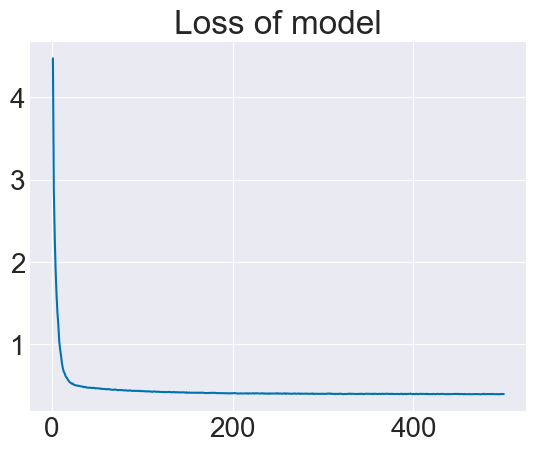

In [264]:
plt.plot([x for x in range(1, num_iter+1)], loss_his)
plt.title("Loss of model")

pred, acc = predict()

print(f'Accuracy of this model training is: {acc:.4f}')

5. Visualize and interpret

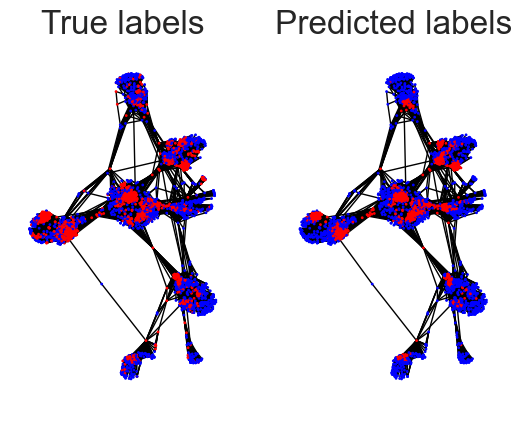

In [265]:
import matplotlib.pyplot as plt

# Color: predicted labels
pos = nx.spring_layout(G, seed=42)  # seed fixes randomness for reproducibility

# Plot TRUE labels
plt.subplot(1, 2, 1)
colors = ['red' if i == 1 else 'blue' for i in labels]
nx.draw(G, pos=pos, node_color=colors, node_size=1)
plt.title("True labels")

# Plot PREDICTED labels
plt.subplot(1, 2, 2)
colors = ['red' if i == 1 else 'blue' for i in pred]
nx.draw(G, pos=pos, node_color=colors, node_size=1)
plt.title("Predicted labels")

plt.show()

* As can be seen from the graphs between, where red = Adopt and blue = non Adopt, the prediction is decently closed. Good point is that is correctly predicts the people in the same circle tend to have the same behaviour, which is shown by the matching of red dot clusters. However, for some seperate red dots from true labels, our prediction was hard to find out them. In short, this confirmed that model successfully captured neighborhood influence structures in the social network, but fail to see the global heterogeneity.

* We gain the accuracy of around 81.83%, this is a resonable rate becasue 
    - adoption was simulated randomly at first, hence, there's only that much signal my features can capture from random seeds. 
    - influence propagation was rule-based, not behavioral, so there’s inherent noise
    - Social networks often exhibit local homophily but global heterogeneity — difficult to fully capture with 2-hop neighborhoods.

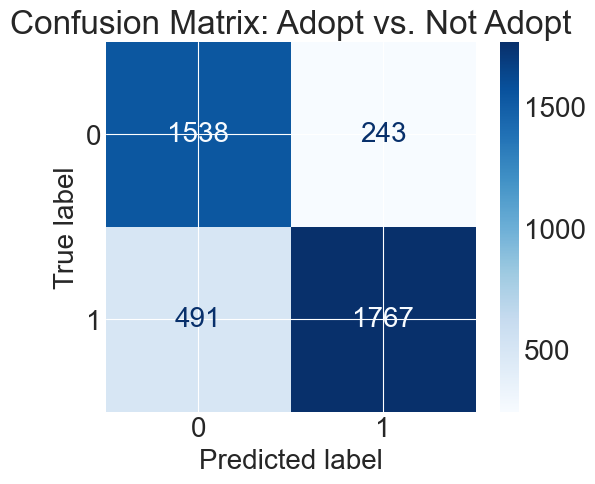

In [266]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = labels.numpy()
predicted_labels = pred.numpy()

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Adopt vs. Not Adopt')
plt.show()

* From this confusion matrix, we focus on he interpretation of errors:
    - False Positives (243): These may be nodes in neighborhoods with strong adopter influence, misleading the model.
    - False Negatives (491): These might be isolated adopters without many adopter neighbors, making them harder to detect

* About the bias: Slightly better at detecting adopters (class 1) in terms of precision (85.1%). Slightly better at detecting non-adopters (class 0) in terms of recall (82.9%).


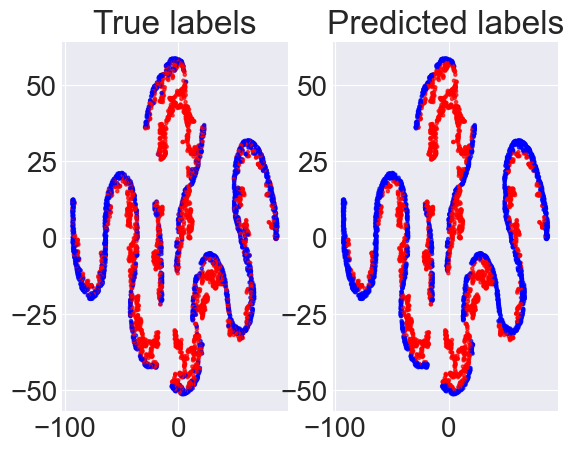

In [267]:
from sklearn.manifold import TSNE
import numpy as np

embeddings = features.to_numpy()

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

plt.subplot(1,2,1)
colors = ['red' if label else 'blue' for label in labels.numpy()]
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=colors, alpha=0.7, s=5)
plt.title("True labels")

plt.subplot(1,2,2)
colors = ['red' if label else 'blue' for label in pred.numpy()]
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=colors, alpha=0.7, s=5)
plt.title("Predicted labels")
plt.show()

* Since t-SNE plot projects the final node embeddings to 2D to visualize clustering of adopters, therefore,while having more understandable visualization, it's giving the same observation to the graph format one. 
* The t-SNE plot confirms that the model successfully captures local neighborhood influence structures. Nodes within the same social circle show similar embedding behavior, evidenced by adopter clusters. 
* However, isolated adopters are harder to predict accurately because the model relies on local aggregation (local messgage passing) and the  influence the global trends (global heterogeneity) of the graph

## Implementation with Spektral format

1. Convert networkx graph to Spektral format

In [268]:
# from spektral.data import Graph, Dataset
# from spektral.transforms import GCNFilter
# import scipy.sparse as sp
# from spektral.utils import normalized_adjacency
# from tensorflow.keras.utils import to_categorical

# # Adjacency matrix
# A = nx.adjacency_matrix(G)
# X = features.to_numpy().astype('float32')
# y = labels.numpy().astype(int) # Ensure labels are integers 0/1, not bool

# A = normalized_adjacency(A).astype('float32')
# y = to_categorical(y)

# class FacebookDataset(Dataset):
#     def read(self):
#         return [Graph(x=X, a=A, y=y)]

# dataset = FacebookDataset(transforms=GCNFilter())

2. Build Graph Convolutional neural network model 

In [269]:
# from spektral.layers import GCNConv
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# class GCN(Model):
#     def __init__(self, channels, n_labels):
#         super().__init__()
#         self.gcn1 = GCNConv(channels, activation = 'relu')
#         self.dropout = Dropout(0.5)
#         self.gcn2 = GCNConv(n_labels, activation = 'softmax')
    
#     def call(self, inputs):
#         x, a = inputs
#         x = self.gcn1([x, a])
#         x = self.drouput(x)
#         output = self.gcn2([x, a])
#         return output 
# n_labels = y.shape[1]
# model = GCN(channels=32, n_labels=n_labels)

3. Training loop

In [270]:
# model.compile(optimizer=Adam(learning_rate=0.003),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Single graph; batch dimension is None
# X, A, Y = dataset[0].x, dataset[0].a, dataset[0].y

# X = np.array(X, dtype='float32')
# A = np.array(A.todense(), dtype='float32')
# Y = np.array(Y, dtype='float32')

# history = model.fit(
#     x=[X, A],
#     y=Y,
#     batch_size=X.shape[0],  # Entire graph at once
#     epochs=200,
#     verbose=2
# )

# # Evaluate
# loss, acc = model.evaluate(x=[X, A], y=Y, batch_size=X.shape[0], verbose=0)
# print(f"\nTest Accuracy: {acc:.4f}")

4. Visualize and interpret
* Currnetly, I fail to implement becasue of the TensorFlow Keras integration with sparse tensors causing repeated errors

## Evaluation and comparison

## Extension
#### Integrate Global Graph Properties in PyG implementation to solve the restrict of local passing
* Limitation: My current model struggles to detect isolated adopters — nodes that adopt the technology but have few or no adopting neighbors. This is a common limitation of standard message-passing GNNs (like GCN, GraphSAGE). 
* Solution: Adding Global Context into the Node Features; or Inject Global Signals Directly into the Model


1. Adding Global Context into the Node Features

In [271]:
constraint = nx.constraint(G)
# tight constraint -> focus more on cluster, wide constraint -> support detecting isolated one
print(constraint)

{0: 0.010754171595626052, 1: 0.09836589784540696, 2: 0.21084287953153508, 3: 0.10018527940937536, 4: 0.32028891054347797, 5: 0.11604552246403282, 6: 0.4141336983046671, 7: 0.10353014147783288, 8: 0.3704251361180954, 9: 0.04829803828478654, 10: 0.12975810678044114, 11: 1.0, 12: 1.0, 13: 0.069098047049821, 14: 0.17087791360242052, 15: 1.0, 16: 0.14963529027046296, 17: 0.16618978961848838, 18: 1.0, 19: 0.1336024878492964, 20: 0.17690545064528915, 21: 0.04186755163514007, 22: 0.13930240229150842, 23: 0.12362671100062428, 24: 0.16163885207741865, 25: 0.04112124184283645, 26: 0.04642629733467657, 27: 0.26094025221403605, 28: 0.18426079391407946, 29: 0.118157419545425, 30: 0.08518986780676102, 31: 0.0810288213795354, 32: 0.34327347785602347, 33: 0.8139429984469599, 34: 0.2252273172162449, 35: 0.5448457762247377, 36: 0.23564513710596705, 37: 1.0, 38: 0.1347853492439566, 39: 0.10102327008685447, 40: 0.05028885025247951, 41: 0.12689484210321125, 42: 0.8139429984469599, 43: 1.0, 44: 0.25246194253

In [272]:
constraint_values = np.array([constraint[node] for node in G.nodes()], dtype=np.float32).reshape(-1, 1)

In [273]:
# Attain global graph statistics 
n_nodes = G.number_of_nodes()
avg_clustering = nx.average_clustering(G)           # 0 to 1: 1 means nodes tend to form tight-knit groups
density = nx.density(G)                             # A value near 1 means most nodes are connected (dense)    

largest_cc = max(nx.connected_components(G), key=len)
G_sub = G.subgraph(largest_cc).copy()
avg_shortest_path = nx.average_shortest_path_length(G_sub)

# Cast all values to float64 explicitly (optional but clear)
avg_clustering = float(avg_clustering)
density = float(density)
avg_shortest_path = float(avg_shortest_path)

# Repeat for every node, ensure dtype is float64 (double)
global_stats = np.array([
    [float(n_nodes), avg_clustering, density, avg_shortest_path]
] * n_nodes, dtype=np.float32)

In [274]:
features_augmented = np.concatenate([features, constraint_values, global_stats], axis=1)
print(features_augmented.shape)

# Optional normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_augmented = scaler.fit_transform(features_augmented)

(4039, 9)


In [275]:
# I rewrote the predict function for this phase to debug 
def predict():
    model.eval()
    total_preds = []
    total_labels = []

    with torch.no_grad():
        loader = NeighborLoader(
            data=G_pyg,
            num_neighbors=[-1],  # full neighborhood
            batch_size=1024,
            shuffle=False
        )

        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)

            # Only keep the predictions and labels for the target (seed) nodes
            seed_nodes = batch.n_id[:batch.batch_size]  # global node indices of targets
            preds = (torch.sigmoid(out[:batch.batch_size]) > 0.5).float()
            labels = batch.y[:batch.batch_size]

            total_preds.append(preds)
            total_labels.append(labels)

    all_preds = torch.cat(total_preds, dim=0)
    all_labels = torch.cat(total_labels, dim=0)

    acc = (all_preds == all_labels).float().mean()
    return all_preds, acc


In [276]:
G_pyg.x = features_augmented.astype(np.float32)

model = GraphSAGEClassifier(in_channels=9, hidden_channels=32).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()            # more statistically stable

# Retrain the model 
train_loader = NeighborLoader(
    data = G_pyg,
    num_neighbors = [10, 5],
    batch_size = 64,
    input_nodes = None
)
loss_his = []
num_iter = 500
for epoch in range(1, num_iter+1):
    loss = train()
    acc = predict()
    loss_his.append(loss)
    print(f'Epoch {epoch}, Loss: {loss:.4f}')


Epoch 1, Loss: 0.6919
Epoch 2, Loss: 0.6414
Epoch 3, Loss: 0.5998
Epoch 4, Loss: 0.5537
Epoch 5, Loss: 0.5097
Epoch 6, Loss: 0.4788
Epoch 7, Loss: 0.4577
Epoch 8, Loss: 0.4409
Epoch 9, Loss: 0.4315
Epoch 10, Loss: 0.4274
Epoch 11, Loss: 0.4222
Epoch 12, Loss: 0.4185
Epoch 13, Loss: 0.4145
Epoch 14, Loss: 0.4130
Epoch 15, Loss: 0.4125
Epoch 16, Loss: 0.4142
Epoch 17, Loss: 0.4085
Epoch 18, Loss: 0.4047
Epoch 19, Loss: 0.4033
Epoch 20, Loss: 0.4061
Epoch 21, Loss: 0.4042
Epoch 22, Loss: 0.3989
Epoch 23, Loss: 0.4015
Epoch 24, Loss: 0.4008
Epoch 25, Loss: 0.4008
Epoch 26, Loss: 0.3969
Epoch 27, Loss: 0.3986
Epoch 28, Loss: 0.3984
Epoch 29, Loss: 0.3975
Epoch 30, Loss: 0.3969
Epoch 31, Loss: 0.3965
Epoch 32, Loss: 0.3985
Epoch 33, Loss: 0.3980
Epoch 34, Loss: 0.3931
Epoch 35, Loss: 0.3946
Epoch 36, Loss: 0.3955
Epoch 37, Loss: 0.3975
Epoch 38, Loss: 0.3920
Epoch 39, Loss: 0.3931
Epoch 40, Loss: 0.3928
Epoch 41, Loss: 0.3929
Epoch 42, Loss: 0.3931
Epoch 43, Loss: 0.3926
Epoch 44, Loss: 0.39

torch.Size([4039])
Accuracy of this model training is: 0.8410


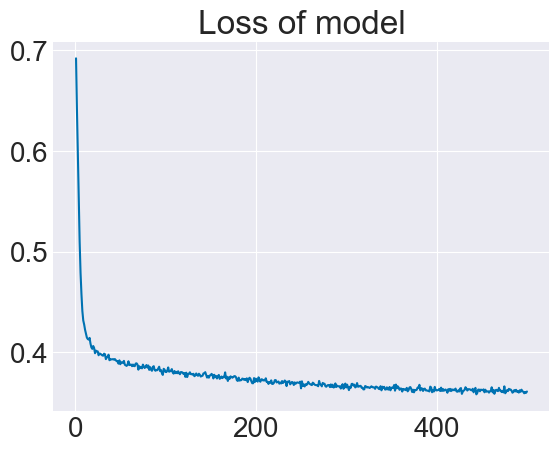

In [277]:
plt.plot([x for x in range(1, num_iter+1)], loss_his)
plt.title("Loss of model")

pred, acc = predict()

print(pred.shape)
print(f'Accuracy of this model training is: {acc:.4f}')

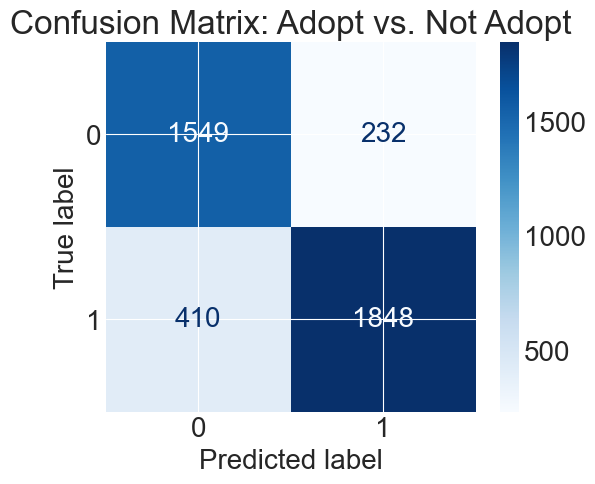

In [279]:
true_labels = labels.numpy()
predicted_labels = pred.numpy()

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Adopt vs. Not Adopt')
plt.show()

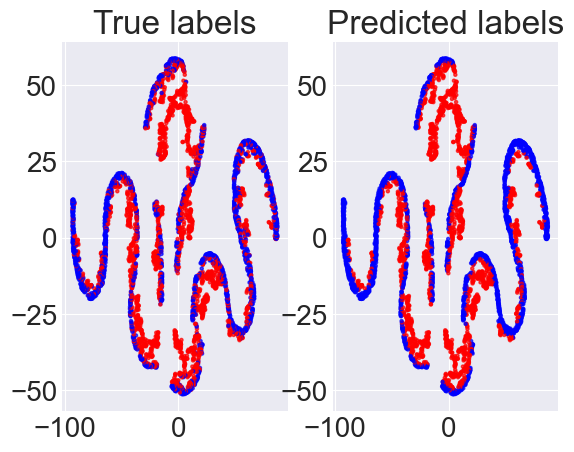

In [280]:
embeddings = features.to_numpy()

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

plt.subplot(1,2,1)
colors = ['red' if label else 'blue' for label in labels.numpy()]
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=colors, alpha=0.7, s=5)
plt.title("True labels")

plt.subplot(1,2,2)
colors = ['red' if label else 'blue' for label in pred.numpy()]
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=colors, alpha=0.7, s=5)
plt.title("Predicted labels")
plt.show()

* Intepretation: We implemented the **"Global Context Injection"** strategy by **adding global graph-level signals** directly into the node features before training.  This method allows all nodes — even the isolated ones — to access high-level summary information about the entire graph.

* Results

| Metric | Before | After |
|--------|--------|-------|
| Accuracy | ~80–81% | **84%** |
| Confusion Matrix (0 → 1) | 243 | **232** |
| Confusion Matrix (1 → 0) | 491 | **410** |

- So, non-adopter misclassified as adopter → slightly reduced, while adopter misclassified as non-adopter → significantly reduced
- From the updated graph visualization:We can now **clearly see isolated adopters**, which were previously misclassified. However, **isolated non-adopters** are still challenging to identify, possibly due to lack of distinctive features for isolated non-adopters


2. Inject global signal directly to the model

In [ ]:
G_pyg.x = torch.tensor(G_pyg.x, dtype=torch.float)

In [404]:
from torch_scatter import scatter_mean

class GCNWithGlobalSignal(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.global_fc = torch.nn.Linear(in_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels * 2, out_channels)

    def forward(self, x, edge_index, global_signal):
        # GCN Layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Expand global signal to each node in batch
        global_signal = self.global_fc(global_signal)
        global_signal = F.relu(global_signal)
        global_signal_node = global_signal.repeat(x.size(0), 1)  # [num_nodes, hidden_channels]

        # Concatenate node features with global signal
        x = torch.cat([x, global_signal_node], dim=1)

        # Final layer
        x = self.lin(x)
        return x

In [405]:
def train():
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        input_n_id = batch.input_id if hasattr(batch, 'input_id') else batch.n_id[:batch.batch_size]
        global_signal = G_pyg.x[input_n_id].mean(dim=0, keepdim=True).to(device)  # [1, in_channels]
        out = model(batch.x, batch.edge_index, global_signal)[:batch.batch_size]
        y_target = batch.y[:batch.batch_size].float()

        loss = criterion(out.squeeze(), y_target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    return total_loss / len(train_loader)

@torch.no_grad()
def predict():
    model.eval()
    x = G_pyg.x.to(device)
    edge_index = G_pyg.edge_index.to(device)
    global_signal = x.mean(dim=0, keepdim=True)
    out = model(x, edge_index, global_signal)
    probs = torch.sigmoid(out.squeeze())
    preds = (probs > 0.5).long()
    y_true = G_pyg.y.to(device).long()

    return preds, (preds == y_true).sum().item()/ y_true.size(0)

In [406]:
model = GCNWithGlobalSignal(in_channels=9, hidden_channels=32, out_channels=1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0)
criterion = torch.nn.BCEWithLogitsLoss()

# Data loader with node-wise task
train_loader = NeighborLoader(
    data=G_pyg,
    num_neighbors=[10, 5],
    batch_size=64,
    input_nodes=torch.arange(G_pyg.num_nodes)
)

# Training loop
loss_his = []
num_iter = 1000
for epoch in range(1, num_iter+1):
    loss = train()
    acc = predict()
    loss_his.append(loss)
    print(f'Epoch {epoch}, Loss: {loss:.4f}')


Epoch 1, Loss: 0.6866
Epoch 2, Loss: 0.6362
Epoch 3, Loss: 0.5952
Epoch 4, Loss: 0.5629
Epoch 5, Loss: 0.5417
Epoch 6, Loss: 0.5299
Epoch 7, Loss: 0.5185
Epoch 8, Loss: 0.5139
Epoch 9, Loss: 0.5101
Epoch 10, Loss: 0.5105
Epoch 11, Loss: 0.5050
Epoch 12, Loss: 0.5043
Epoch 13, Loss: 0.5011
Epoch 14, Loss: 0.4974
Epoch 15, Loss: 0.4966
Epoch 16, Loss: 0.4894
Epoch 17, Loss: 0.4906
Epoch 18, Loss: 0.4869
Epoch 19, Loss: 0.4890
Epoch 20, Loss: 0.4846
Epoch 21, Loss: 0.4840
Epoch 22, Loss: 0.4859
Epoch 23, Loss: 0.4786
Epoch 24, Loss: 0.4772
Epoch 25, Loss: 0.4805
Epoch 26, Loss: 0.4737
Epoch 27, Loss: 0.4802
Epoch 28, Loss: 0.4744
Epoch 29, Loss: 0.4767
Epoch 30, Loss: 0.4731
Epoch 31, Loss: 0.4751
Epoch 32, Loss: 0.4748
Epoch 33, Loss: 0.4723
Epoch 34, Loss: 0.4718
Epoch 35, Loss: 0.4705
Epoch 36, Loss: 0.4707
Epoch 37, Loss: 0.4694
Epoch 38, Loss: 0.4642
Epoch 39, Loss: 0.4709
Epoch 40, Loss: 0.4686
Epoch 41, Loss: 0.4654
Epoch 42, Loss: 0.4656
Epoch 43, Loss: 0.4661
Epoch 44, Loss: 0.46

Accuracy of this model training is: 0.7192


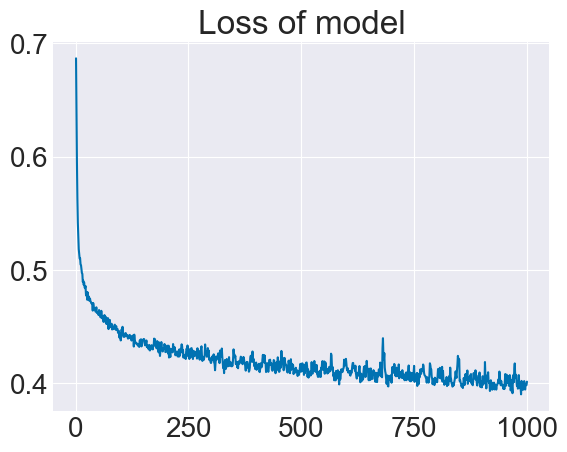

In [407]:
plt.plot([x for x in range(1, num_iter+1)], loss_his)
plt.title("Loss of model")

pred, acc = predict()

print(f'Accuracy of this model training is: {acc:.4f}')

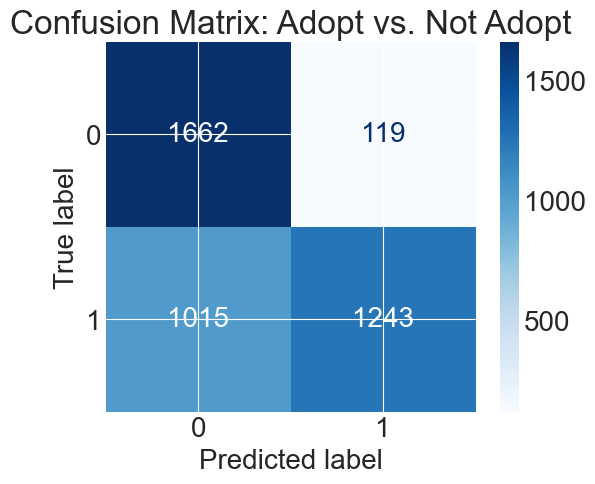

In [408]:
true_labels = labels.numpy()
predicted_labels = pred.numpy()

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Adopt vs. Not Adopt')
plt.show()

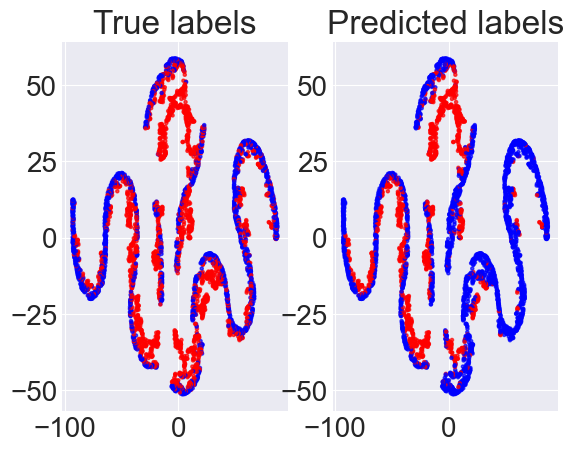

In [409]:
embeddings = features.to_numpy()

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

plt.subplot(1,2,1)
colors = ['red' if label else 'blue' for label in labels.numpy()]
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=colors, alpha=0.7, s=5)
plt.title("True labels")

plt.subplot(1,2,2)
colors = ['red' if label else 'blue' for label in pred.numpy()]
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=colors, alpha=0.7, s=5)
plt.title("Predicted labels")
plt.show()

* Interpretation
    1. Overall Accuracy Drop (72%)
        - The model reached an **accuracy of 72%**, which initially seems acceptable.
        - However, this is **lower than the accuracy achieved in the previous implementation**, 
        - The model may have lost access to **important global structural information**, which was previously beneficial.

    2. Confusion Matrix Analysis
        - There are **1015 false negatives**, meaning the model often fails to detect true adopters.
        - Only **119 false positives**, so the model is much more cautious about predicting adoption.
        - This suggests a **strong bias toward predicting class 0 (non-adopter)**.

    3. Graph Visualization Insight
        - The visualization shows that the model still captures some **global structural patterns**—such as adopter clusters.
        - However, these insights **aren’t effectively leveraged** during classification due to the limited view provided by `NeighborLoader`.
        - As a result, even though the overall pattern looks good, **node-level predictions are dominated by non-adopter labels**.

* Summary
    - The model is **overly conservative**, favoring non-adopter predictions.
    - Training on **local subgraphs** has caused a **loss of global context**, which seems crucial for predicting adoption behavior.
    - **Imbalanced predictions** indicate the need for either better sampling, loss weighting, or additional features.